In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_blocks(series):
    blocks = series.ne(series.shift()).cumsum()
    firsts = blocks.drop_duplicates()
    return blocks, firsts

In [2]:
all_dfs = {}
results = {}
for side in ['L','R']:  
    for n in range(5):
        df = pd.read_csv(f'../results/row{side}-{n}.csv',index_col=0).fillna(0)
        for s in ['window','middle','aisle']:
            results[f'row{side}-{n}-{s}'] = {}
            seat = f'{s} occupied'
            blocks, firsts = get_blocks(df[seat])
            sizes = blocks.groupby(blocks).size()
            for b in sizes[sizes<20].index:
                new_value = df.loc[firsts[firsts==(b-1)].index,seat].values[0] if b!=1 else 0
                df.loc[blocks==b,seat] = new_value
                if new_value==0:
                    df.loc[blocks==b,f'{s} facing'] = 0
                    df.loc[blocks==b,f'{s} face touch'] = 0
                
            blocks,firsts = get_blocks(df[seat])
            values = df.loc[firsts.index,seat]
            if len(values)>1:
                results[f'row{side}-{n}-{s}']['corrections'] = sizes[sizes<20].sum()
                
                boarded = values[values==1].index[0]
                departed = values[values==0].index[-1]-15
                ind_left = (values.loc[boarded:departed]==0).values
                sizes = blocks.loc[boarded:departed].groupby(blocks).size()
                facing = df[f'{s} facing'].replace(0, np.nan).value_counts()
                _, face_touchs = get_blocks(df.loc[boarded:departed,f'{s} face touch'])

                
                results[f'row{side}-{n}-{s}']['boarded'] = boarded/15
                results[f'row{side}-{n}-{s}']['departed'] = departed/15
                results[f'row{side}-{n}-{s}']['in seat'] = sizes[~ind_left].sum()
                results[f'row{side}-{n}-{s}']['out seat'] = sizes[ind_left].sum()
                results[f'row{side}-{n}-{s}']['num out'] = ind_left.sum()
                results[f'row{side}-{n}-{s}']['time out'] = sizes[ind_left].mean() if ind_left.sum()!=0 else 0
                results[f'row{side}-{n}-{s}']['face touch'] = len(face_touchs)
                results[f'row{side}-{n}-{s}']['facing forward'] = facing['forward']/facing.sum()
                


        if side == 'L':
            window_middle = ((df['window facing']=='right') & (df['middle facing']=='left')).sum()
            middle_aisle = ((df['middle facing']=='right') & (df['aisle facing']=='left')).sum()
            window_aisle = ((df['window facing']=='right') & (df['aisle facing']=='left')).sum()
        elif side == 'R':
            window_middle = ((df['window facing']=='left') & (df['middle facing']=='right')).sum()
            middle_aisle = ((df['middle facing']=='left') & (df['aisle facing']=='right')).sum()
            window_aisle = ((df['window facing']=='left') & (df['aisle facing']=='right')).sum()
        results[f'row{side}-{n}-window']['window_middle'] = window_middle
        results[f'row{side}-{n}-window']['window_aisle'] = window_aisle
        results[f'row{side}-{n}-middle']['window_middle'] = window_middle
        results[f'row{side}-{n}-middle']['middle_aisle'] = middle_aisle
        results[f'row{side}-{n}-aisle']['middle_aisle'] = middle_aisle
        results[f'row{side}-{n}-aisle']['window_aisle'] = window_aisle
        all_dfs[f'row{side}-{n}'] = df
all_dfs = pd.concat(all_dfs,axis=1)

In [3]:
stats = pd.DataFrame(results).T.dropna(thresh=3)
stats['facing other'] = stats.iloc[:,-3:].sum(axis=1)
stats

,corrections,boarded,departed,in seat,out seat,num out,time out,face touch,facing forward,window_middle,window_aisle,middle_aisle,facing other
rowL-0-window,191.0,212.0,7952.0,7741.0,0.0,0.0,0.000000,135.0,0.802180,184.0,25.0,NaN,209.0
rowL-0-middle,54.0,242.0,7843.0,7602.0,0.0,0.0,0.000000,209.0,0.878525,184.0,NaN,1.0,185.0
rowL-0-aisle,158.0,59.0,7970.0,7630.0,282.0,2.0,141.000000,335.0,0.960779,NaN,25.0,1.0,26.0
rowL-1-window,9.0,332.0,8026.0,7695.0,0.0,0.0,0.000000,539.0,0.927975,5.0,69.0,NaN,74.0
rowL-1-middle,44.0,501.0,8015.0,7515.0,0.0,0.0,0.000000,299.0,0.961312,5.0,NaN,2.0,7.0
rowL-1-aisle,233.0,363.0,8023.0,7661.0,0.0,0.0,0.000000,157.0,0.960180,NaN,69.0,2.0,71.0
rowL-2-middle,487.0,620.0,8128.0,7298.0,211.0,3.0,70.333333,513.0,0.671922,0.0,NaN,0.0,0.0
rowL-3-window,624.0,163.0,8005.0,7843.0,0.0,0.0,0.000000,187.0,0.519585,513.0,2967.0,NaN,3480.0
rowL-3-middle,52.0,176.0,8011.0,7737.0,99.0,1.0,99.000000,77.0,0.614558,513.0,NaN,1886.0,2399.0
rowL-3-aisle,33.0,513.0,7752.0,7044.0,196.0,2.0,98.000000,279.0,0.204708,NaN,2967.0,1886.0,4853.0


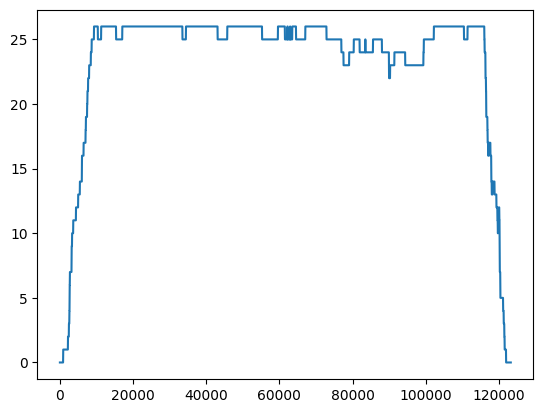

In [4]:
idx = pd.IndexSlice
plt.plot(all_dfs.loc[idx[:],idx[:,[f'{s} occupied' for s in ['window','middle','aisle']]]].sum(axis=1))
plt.show()

In [5]:
all_dfs.loc[idx[:],idx[:,'window touch']].sum(axis=0)

rowL-0  window touch     27.0
rowL-1  window touch      5.0
rowL-3  window touch      8.0
rowL-4  window touch    138.0
rowR-0  window touch      1.0
rowR-1  window touch      8.0
rowR-2  window touch      5.0
rowR-3  window touch      5.0
rowR-4  window touch      3.0
dtype: float64

In [3]:
all_dfs

rowL-0                                            \
         aisle occupied aisle facing aisle angle aisle face touch   
frame_id                                                            
0                   0.0            0         0.0              0.0   
15                  0.0            0         0.0              0.0   
30                  0.0            0         0.0              0.0   
45                  0.0            0         0.0              0.0   
60                  0.0            0         0.0              0.0   
...                 ...          ...         ...              ...   
123180              NaN          NaN         NaN              NaN   
123195              NaN          NaN         NaN              NaN   
123210              NaN          NaN         NaN              NaN   
123225              NaN          NaN         NaN              NaN   
123240              NaN          NaN         NaN              NaN   

                                                                     \
         aisle num touch window occupied window facing window angle   
frame_id                                                              
0                    0.0             0.0             0          0.0   
15                   0.0             0.0             0          0.0   
30                   0.0             0.0             0          0.0   
45                   0.0             0.0             0          0.0   
60                   0.0             0.0             0          0.0   
...                  ...             ...           ...          ...   
123180               NaN             NaN           NaN          NaN   
123195               NaN             NaN           NaN          NaN   
123210               NaN             NaN           NaN          NaN   
123225               NaN             NaN           NaN          NaN   
123240               NaN             NaN           NaN          NaN   

                                        ...        rowR-4               \
         window touch window num touch  ... middle facing middle angle   
frame_id                                ...                              
0                 0.0              0.0  ...             0          0.0   
15                0.0              0.0  ...             0          0.0   
30                0.0              0.0  ...             0          0.0   
45                0.0              0.0  ...             0          0.0   
60                0.0              0.0  ...             0          0.0   
...               ...              ...  ...           ...          ...   
123180            NaN              NaN  ...             0          0.0   
123195            NaN              NaN  ...             0          0.0   
123210            NaN              NaN  ...             0          0.0   
123225            NaN              NaN  ...             0          0.0   
123240            NaN              NaN  ...             0          0.0   

                                                                   \
         aisle occupied aisle facing aisle angle aisle face touch   
frame_id                                                            
0                   0.0            0         0.0              0.0   
15                  0.0            0         0.0              0.0   
30                  0.0            0         0.0              0.0   
45                  0.0            0         0.0              0.0   
60                  0.0            0         0.0              0.0   
...                 ...          ...         ...              ...   
123180              0.0            0         0.0              0.0   
123195              0.0            0         0.0              0.0   
123210              0.0            0         0.0              0.0   
123225              0.0            0         0.0              0.0   
123240              0.0            0         0.0              0.0   

                                                   